### INTRO

RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns. The system assigns each customer numerical scores based on these factors to provide an objective analysis. RFM analysis is based on the marketing adage that "80% of your business comes from 20% of your customers."

Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy.

#### Main goals of the project:</br>
+ split similar customers into groups (clusters)
+ get to know how much money every group of customers spent and how often they come
+ establish best seling combos products

#### Importing libraries

In [1]:
#!pip install mlxtend
#!pip install threadpoolctl==3.1.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

In [3]:
df=pd.read_csv("C:/Users/msoln/Desktop/basket/market.csv",sep=';', dtype='unicode')
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850,United Kingdom


<h3> Basic statictic </h3>

In [4]:
df.describe()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
count,522064,520609,522064,522064,522064,388023,522064
unique,21663,4185,690,19641,1285,4297,30
top,573585,WHITE HANGING HEART T-LIGHT HOLDER,1,31.10.2011 14:41,"1,25",17841,United Kingdom
freq,1114,2269,147848,1114,48778,7847,487622


<h3> checking for null values </h3>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   BillNo      522064 non-null  object
 1   Itemname    520609 non-null  object
 2   Quantity    522064 non-null  object
 3   Date        522064 non-null  object
 4   Price       522064 non-null  object
 5   CustomerID  388023 non-null  object
 6   Country     522064 non-null  object
dtypes: object(7)
memory usage: 27.9+ MB


In [6]:
print(df.isna().sum())

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
dtype: int64


<h4> There is no need to delete any rows</h4>
+ CustomerId is not relevant variable <br>
+ Itemname can be nullable

### RMF analysis
+ Recency. How recent was the customer's last purchase? Customers who recently made a purchase will still have the product on their mind and are more likely to purchase or use the product again. Businesses often measure recency in days. But, depending on the product, they may measure it in years, weeks or even hours.
+ Frequency. How often did this customer make a purchase in a given period? Customers who purchased once are often are more likely to purchase again. Additionally, first time customers may be good targets for follow-up advertising to convert them into more frequent customers.
+ Monetary. How much money did the customer spend in a given period? Customers who spend a lot of money are more likely to spend money in the future and have a high value to a business.

In [7]:
today = "2012-01-01"
today = pd.to_datetime(today)
df["Date"] = pd.to_datetime(df["Date"])
#recency
rec_table=df.groupby(['CustomerID']).agg({"Date": lambda x: ((today - x.max()).days)})
rec_table.columns=['Recency']
print(rec_table.head())

            Recency
CustomerID         
12346           347
12347            61
12349            40
12350           332
12352            94


In [8]:
#frequency
frq_table=df.drop_duplicates(['BillNo']).groupby(['CustomerID'])[['BillNo']].count()
frq_table.columns=['frequency']
frq_table.head()

,frequency
CustomerID,
12346,1
12347,7
12349,1
12350,1
12352,8


In [9]:
df["Price"] = df["Price"].str.replace(",",".")
df["Price"] = df["Price"].astype("float64")
df['Quantity']=df['Quantity'].astype("float64")
#monetary
df["Total"]=df['Price']*df['Quantity']
mon_table=df.groupby(['CustomerID'])[['Total']].sum()

In [10]:
#creating summary table
rmf_table=pd.concat([mon_table,frq_table,rec_table],axis=1)
print(rmf_table.head())

               Total  frequency  Recency
CustomerID                              
12346       77183.60          1      347
12347        4310.00          7       61
12349        1757.55          1       40
12350         334.40          1      332
12352        2506.04          8       94


In [11]:
rmf_table.describe()

,Total,frequency,Recency
count,4297.000000,4297.000000,4297.000000
mean,1993.140888,4.226902,126.545264
std,8588.143093,7.090722,115.234387
min,0.000000,1.000000,21.000000
25%,306.720000,1.000000,43.000000
50%,668.580000,2.000000,82.000000
75%,1652.580000,5.000000,183.000000
max,280206.020000,210.000000,718.000000


## scaling data 

In [12]:
scaler=StandardScaler()
rmf_scaled=scaler.fit_transform(rmf_table)

### ML method
+ Kmeans clustering 

In [13]:
inertia=[]
for k in range(1,6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(rmf_scaled)
    inertia.append(kmeans.inertia_)

#### Plot

Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

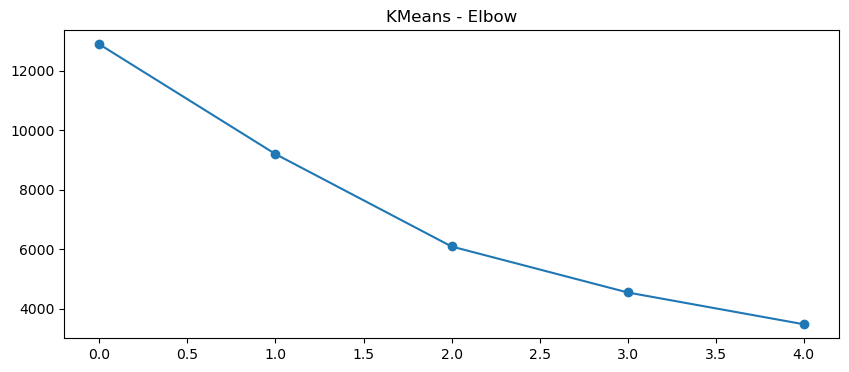

In [14]:
plt.figure(figsize = (10,4))    
plt.plot(inertia, marker = "o")
plt.title("KMeans - Elbow");

 + Let's use 3 clusters to group similar customers


In [15]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(rmf_scaled)
rmf_table['Nr_Cluster']=(kmeans.labels_+1)

In [16]:
rmf_table.head().sort_values(by='Nr_Cluster')

,Total,frequency,Recency,Nr_Cluster
CustomerID,,,,
12346,77183.60,1,347,1
12350,334.40,1,332,2
12347,4310.00,7,61,3
12349,1757.55,1,40,3
12352,2506.04,8,94,3


In [17]:
final=rmf_table.groupby("Nr_Cluster")[['frequency','Recency','Total']].mean()

#### customer segmentation
#### 3 clusters

In [18]:
final

,frequency,Recency,Total
Nr_Cluster,,,
1,58.960000,48.760000,81979.682000
2,1.545299,281.745299,495.484189
3,4.797228,68.634429,1913.384218


#### barchart with 3 clusters, segmentation by Monetary

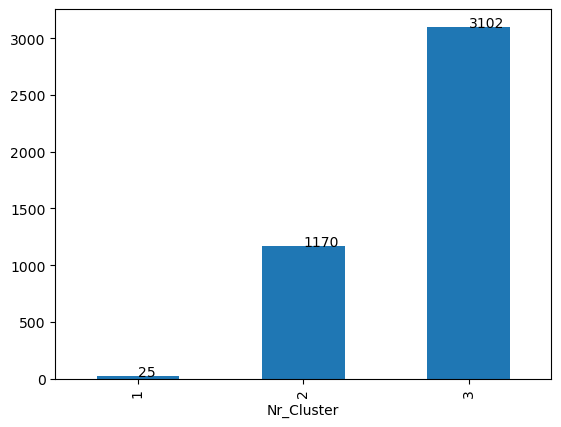

In [22]:
cluster_count=rmf_table.groupby('Nr_Cluster')['Total'].count()
cluster_count.plot(kind='bar')
for index, value in enumerate(cluster_count):
    plt.text(index,value, str(value))
plt.show()

<h2> Findings </h2>
<h3>Cluster 1</h3>
+  Those customers are making the most profit, they are spending a lot money<br>
+  They have a lot transaction, they are ferquent
<h3>Cluster 2</h3>
+  They are not very valuable to business
<h3>Cluster 3</h3>
+  They are avarage<br>
+  They spent normally<br>
+  they come from time to time<br>

<h2> Market basket </h2>

In [35]:
items=list(df['Itemname'].unique())
n=len(items)

In [41]:
print("There is  {0} unique items on transaction bills".format(n))

There is  4186 unique items on transaction bills


### Let's print some labels to see how they look

In [21]:
items[:10]

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'ASSORTED COLOUR BIRD ORNAMENT']

In [23]:
data_b = df.groupby(["BillNo", "Itemname"])[["Quantity"]].sum(
).unstack().reset_index().fillna(0).set_index("BillNo")

In [24]:
data_b.head()

Quantity                                                 \
Itemname *Boombox Ipod Classic *USB Office Mirror Ball 10 COLOUR SPACEBOY PEN   
BillNo                                                                          
536365                     0.0                     0.0                    0.0   
536366                     0.0                     0.0                    0.0   
536367                     0.0                     0.0                    0.0   
536368                     0.0                     0.0                    0.0   
536369                     0.0                     0.0                    0.0   

                                                               \
Itemname 12 COLOURED PARTY BALLOONS 12 DAISY PEGS IN WOOD BOX   
BillNo                                                          
536365                          0.0                       0.0   
536366                          0.0                       0.0   
536367                          0.0                       0.0   
536368                          0.0                       0.0   
536369                          0.0                       0.0   

                                                                 \
Itemname 12 EGG HOUSE PAINTED WOOD 12 HANGING EGGS HAND PAINTED   
BillNo                                                            
536365                         0.0                          0.0   
536366                         0.0                          0.0   
536367                         0.0                          0.0   
536368                         0.0                          0.0   
536369                         0.0                          0.0   

                                                                           \
Itemname 12 IVORY ROSE PEG PLACE SETTINGS 12 MESSAGE CARDS WITH ENVELOPES   
BillNo                                                                      
536365                                0.0                             0.0   
536366                                0.0                             0.0   
536367                                0.0                             0.0   
536368                                0.0                             0.0   
536369                                0.0                             0.0   

                                        ...                      \
Itemname 12 PENCIL SMALL TUBE WOODLAND  ... wrongly coded 20713   
BillNo                                  ...                       
536365                             0.0  ...                 0.0   
536366                             0.0  ...                 0.0   
536367                             0.0  ...                 0.0   
536368                             0.0  ...                 0.0   
536369                             0.0  ...                 0.0   

                                                                 \
Itemname wrongly coded 23343 wrongly coded-23343 wrongly marked   
BillNo                                                            
536365                   0.0                 0.0            0.0   
536366                   0.0                 0.0            0.0   
536367                   0.0                 0.0            0.0   
536368                   0.0                 0.0            0.0   
536369                   0.0                 0.0            0.0   

                                                           \
Itemname wrongly marked 23343 wrongly marked carton 22804   
BillNo                                                      
536365                    0.0                         0.0   
536366                    0.0                         0.0   
536367                    0.0                         0.0   
536368                    0.0                         0.0   
536369                    0.0                         0.0   

                                                                    \
Itemname wrongly marked. 23343 in box wrongly sold (22719) barcod

In [25]:
def one_hot_encoding(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
data_b = data_b.applymap(one_hot_encoding)

In [26]:
data_b.head()

Quantity                                                 \
Itemname *Boombox Ipod Classic *USB Office Mirror Ball 10 COLOUR SPACEBOY PEN   
BillNo                                                                          
536365                       0                       0                      0   
536366                       0                       0                      0   
536367                       0                       0                      0   
536368                       0                       0                      0   
536369                       0                       0                      0   

                                                               \
Itemname 12 COLOURED PARTY BALLOONS 12 DAISY PEGS IN WOOD BOX   
BillNo                                                          
536365                            0                         0   
536366                            0                         0   
536367                            0                         0   
536368                            0                         0   
536369                            0                         0   

                                                                 \
Itemname 12 EGG HOUSE PAINTED WOOD 12 HANGING EGGS HAND PAINTED   
BillNo                                                            
536365                           0                            0   
536366                           0                            0   
536367                           0                            0   
536368                           0                            0   
536369                           0                            0   

                                                                           \
Itemname 12 IVORY ROSE PEG PLACE SETTINGS 12 MESSAGE CARDS WITH ENVELOPES   
BillNo                                                                      
536365                                  0                               0   
536366                                  0                               0   
536367                                  0                               0   
536368                                  0                               0   
536369                                  0                               0   

                                        ...                      \
Itemname 12 PENCIL SMALL TUBE WOODLAND  ... wrongly coded 20713   
BillNo                                  ...                       
536365                               0  ...                   0   
536366                               0  ...                   0   
536367                               0  ...                   0   
536368                               0  ...                   0   
536369                               0  ...                   0   

                                                                 \
Itemname wrongly coded 23343 wrongly coded-23343 wrongly marked   
BillNo                                                            
536365                     0                   0              0   
536366                     0                   0              0   
536367                     0                   0              0   
536368                     0                   0              0   
536369                     0                   0              0   

                                                           \
Itemname wrongly marked 23343 wrongly marked carton 22804   
BillNo                                                      
536365                      0                           0   
536366                      0                           0   
536367                      0                           0   
536368                      0                           0   
536369                      0                           0   

                                                                    \
Itemname wrongly marked. 23343 in box wrongly sold (22719) barcod

In [28]:
frequent_itemsets = apriori(data_b, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values("lift", ascending = False)

C:\Users\msoln\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [29]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
152,"((Quantity, GREEN REGENCY TEACUP AND SAUCER), ...","((Quantity, PINK REGENCY TEACUP AND SAUCER))",0.036174,0.036421,0.025485,0.704514,19.343514,0.024167,3.261000,0.983894
157,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, GREEN REGENCY TEACUP AND SAUCER), ...",0.036421,0.036174,0.025485,0.699728,19.343514,0.024167,3.209847,0.984147
154,"((Quantity, ROSES REGENCY TEACUP AND SAUCER), ...","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.028207,0.048248,0.025485,0.903509,18.726262,0.024124,9.863609,0.974074
155,"((Quantity, GREEN REGENCY TEACUP AND SAUCER))","((Quantity, ROSES REGENCY TEACUP AND SAUCER), ...",0.048248,0.028207,0.025485,0.528205,18.726262,0.024124,2.059779,0.994586
24,"((Quantity, GREEN REGENCY TEACUP AND SAUCER))","((Quantity, PINK REGENCY TEACUP AND SAUCER))",0.048248,0.036421,0.029939,0.620513,17.037124,0.028181,2.539160,0.989023
...,...,...,...,...,...,...,...,...,...,...
149,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, WOODEN PICTURE FRAME WHITE FINISH))",0.108967,0.054038,0.020042,0.183924,3.403599,0.014153,1.159159,0.792556
131,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, NATURAL SLATE HEART CHALKBOARD))",0.108967,0.060966,0.020338,0.186649,3.061520,0.013695,1.154524,0.755712
130,"((Quantity, NATURAL SLATE HEART CHALKBOARD))","((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))",0.060966,0.108967,0.020338,0.333604,3.061520,0.013695,1.337093,0.717083
81,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, JUMBO BAG RED RETROSPOT))",0.108967,0.102138,0.021873,0.200727,1.965254,0.010743,1.123348,0.551225


In [30]:
ff=pd.concat([rules['antecedents'],rules['consequents'],rules['confidence']],axis=1).sort_values('confidence',ascending=False)

In [31]:
ff

,antecedents,consequents,confidence
154,"((Quantity, ROSES REGENCY TEACUP AND SAUCER), ...","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.903509
153,"((Quantity, GREEN REGENCY TEACUP AND SAUCER), ...","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.851240
25,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.822011
159,"((Quantity, JUMBO STORAGE BAG SUKI), (Quantity...","((Quantity, JUMBO BAG RED RETROSPOT))",0.801556
139,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.774457
...,...,...,...
70,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO STORAGE BAG SKULLS))",0.200097
162,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO STORAGE BAG SUKI), (Quantity...",0.199612
42,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO BAG ALPHABET))",0.199128
131,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, NATURAL SLATE HEART CHALKBOARD))",0.186649
